#  Study of airflight delay causes with Self Organizing Maps - Example of hexagonal lattice

This notebook is intended to be a brief guide on how to use Self Organizing Maps with the **SOMPY** library in Python. We are going to use hexagonal lattice in this example in order to understand the main causes of airflight cancellations

##### Data description
________________________

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled and diverted flights appears in DOT's monthly Air Travel Consumer Report, published about 30 days after the month's end, as well as in summary tables posted on this website. BTS began collecting details on the causes of flight delays in June 2003. Summary statistics and raw data are made available to the public at the time the Air Travel Consumer Report is released.

This version of the dataset was compiled from the Statistical Computing Statistical Graphics 2009 Data Expo and is also available [here](http://stat-computing.org/dataexpo/2009/the-data.html), [here](https://www.transtats.bts.gov/Fields.asp?Table_ID=236) and [here](https://www.kaggle.com/giovamata/airlinedelaycauses)

**Fields description**
__________________________
1.	**Year**:	2008
2.	**Month**:	1-12
3.	**DayofMonth**:	1-31
4.	**DayOfWeek**:	1 (Monday) - 7 (Sunday)
5.	**DepTime**:	actual departure time (local, hhmm)
6.	**CRSDepTime**:	scheduled departure time (local, hhmm)
7.	**ArrTime**:	actual arrival time (local, hhmm)
8.	**CRSArrTime**:	scheduled arrival time (local, hhmm)
9.	**UniqueCarrier**:	unique carrier code
10.	**FlightNum**:	flight number
11.	**TailNum**:	plane tail number
12.	**ActualElapsedTime**:	in minutes
13.	**CRSElapsedTime**:	in minutes
14.	**AirTime**:	in minutes
15.	**ArrDelay**:	arrival delay, in minutes
16.	**DepDelay**:	departure delay, in minutes
17.	**Origin**:	origin IATA airport code
18.	**Dest**:	destination IATA airport code
19.	**Distance**:	in miles
20.	**TaxiIn**:	taxi in time, in minutes
21.	**TaxiOut**:	taxi out time in minutes
22.	**Cancelled**:	was the flight cancelled?
23.	**CancellationCode**:	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24.	**Diverted**:	1 = yes, 0 = no
25.	**CarrierDelay**:	in minutes
26.	**WeatherDelay**:	in minutes
27.	**NASDelay**:	National Air System delay in minutes
28.	**SecurityDelay**	in minutes
29.	**LateAircraftDelay**	in minutes

In [1]:
%matplotlib inline
import math
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib3
from sklearn.externals import joblib
import random
import matplotlib
from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging


backend module://ipykernel.pylab.backend_inline version unknown


## Data Processing

In [2]:
df = pd.read_csv("./DelayedFlights.csv")

df = df[["Month","DayofMonth", "DayOfWeek","DepTime", "AirTime",
         "Distance", "SecurityDelay","WeatherDelay", "NASDelay", "CarrierDelay",
         "ArrDelay", "DepDelay", "LateAircraftDelay", "Cancelled"]]
clustering_vars = ["Month", "DayofMonth", "DepTime", "AirTime", 
                   "LateAircraftDelay", "DepDelay", "ArrDelay", "CarrierDelay"]
df = df.fillna(0)
data = df[clustering_vars].values
names = clustering_vars

In [3]:
df.describe()

Month    DayofMonth     DayOfWeek       DepTime       AirTime  \
count  1.936758e+06  1.936758e+06  1.936758e+06  1.936758e+06  1.936758e+06   
mean   6.111106e+00  1.575347e+01  3.984827e+00  1.518534e+03  1.078083e+02   
std    3.482546e+00  8.776272e+00  1.995966e+00  4.504853e+02  6.886184e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    3.000000e+00  8.000000e+00  2.000000e+00  1.203000e+03  5.800000e+01   
50%    6.000000e+00  1.600000e+01  4.000000e+00  1.545000e+03  9.000000e+01   
75%    9.000000e+00  2.300000e+01  6.000000e+00  1.900000e+03  1.370000e+02   
max    1.200000e+01  3.100000e+01  7.000000e+00  2.400000e+03  1.091000e+03   

           Distance  SecurityDelay  WeatherDelay      NASDelay  CarrierDelay  \
count  1.936758e+06   1.936758e+06  1.936758e+06  1.936758e+06  1.936758e+06   
mean   7.656862e+02   5.805836e-02  2.385512e+00  9.675607e+00  1.235367e+01   
std    5.744797e+02   1.623934e+00  1.734036e+01  2.808958e+01  3.613493e+01   
min    1.100000e+01   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.380000e+02   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    6.060000e+02   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    9.980000e+02   0.000000e+00  0.000000e+00  6.000000e+00  1.000000e+01   
max    4.962000e+03   3.920000e+02  1.352000e+03  1.357000e+03  2.436000e+03   

           ArrDelay      DepDelay  LateAircraftDelay     Cancelled  
count  1.936758e+06  1.936758e+06       1.936758e+06  1.936758e+06  
mean   4.201714e+01  4.318518e+01       1.629374e+01  3.268348e-04  
std    5.672935e+01  5.340250e+01       3.585904e+01  1.807562e-02  
min   -1.090000e+02  6.000000e+00       0.000000e+00  0.000000e+00  
25%    9.000000e+00  1.200000e+01       0.000000e+00  0.000000e+00  
50%    2.400000e+01  2.400000e+01       0.000000e+00  0.000000e+00  
75%    5.500000e+01  5.300000e+01       1.800000e+01  0.000000e+00  
max    2.461000e+03  2.467000e+03       1.316000e+03  1.000000e+00

## Model Training 

As the data is relatively high, the model takes some time to train. We didn't finetune the hyperparameters of the algorithm and this is a potential improvement topic.

In [ ]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool = glob.glob("./model*")
errors=[]
for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top, e_q = zip(*errors)

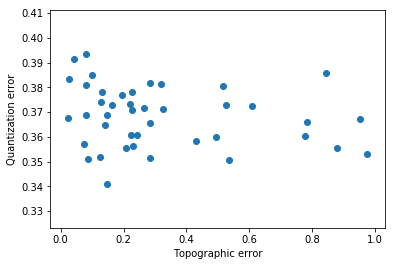

In [11]:
plt.scatter(e_top, e_q)
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()

In [5]:
# Manually select the model with better features. In this case, the #3 model has been selected because
# quantization error is distributed across 34-40u and the topographic error varies much more,
# so the model with lower topographic error has been selected. It is very important to keep the topographic
# error as low as possible to assure a correct prototyping.
selected_model = 3
sm = joblib.load(models_pool[selected_model])

topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error = %s\n Quantization error = %s" % (topographic_error, quantization_error))

 find_bmu took: 11.261000 seconds
 find_bmu took: 13.157000 seconds
 find_bmu took: 12.016000 seconds


Topographic error = 0.024276135686544215
 Quantization error = 0.36751687454158743


## Results 

### Components plane 

The components map shows the values of the variables for each prototype and allows us to extract conclusions consisting of non-linear patterns between variables. We have represented 2 types of components maps.
- The **prototypes visualization**: it shows the patterns learned by the neural network which are used to determine de winning neuron of each training instance
- The **real visualization** with exogeneous variables: it shows the real average value of the components of each lattice element. This visualization should be used with 2 purposes: (i) compare it with the prototypes visualization to assess how good is the prototypes modeling and (ii) to add other exogeneous variables (those which have not been used to build the self organizing map) in order to study their relation with the endogeneous variables.

If the quantization error is not very high and a proper visual assessment has been done assuring that the prototupes and real visualizations look very alike, the prototypes visualization can be used as a final product, since it is much visual appealing.

#### Prototypes component plane

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.4 to DejaVu Sans ('C:\\Users\\Ivan Valles Perez\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=7.0 to DejaVu Sans ('C:\\Users\\Ivan Valles Perez\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


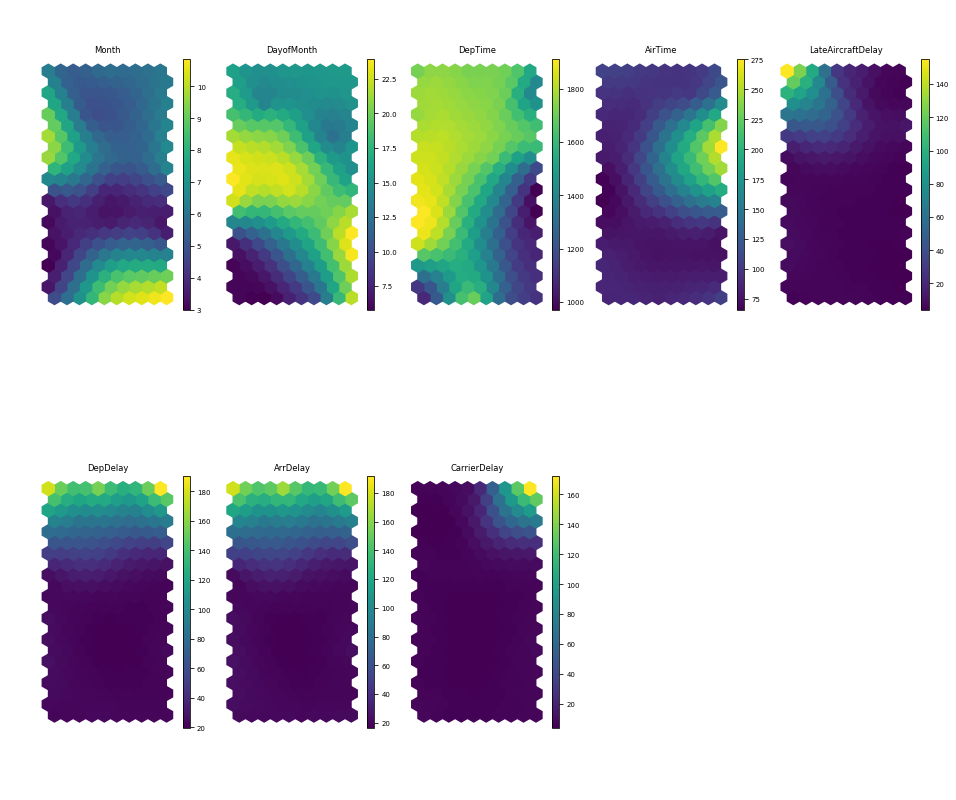

In [6]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"", text_size=7)
view2D.show(sm, col_sz=5, which_dim="all", denormalize=True)
plt.show()

#### Real values component plane

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\Users\\Ivan Valles Perez\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


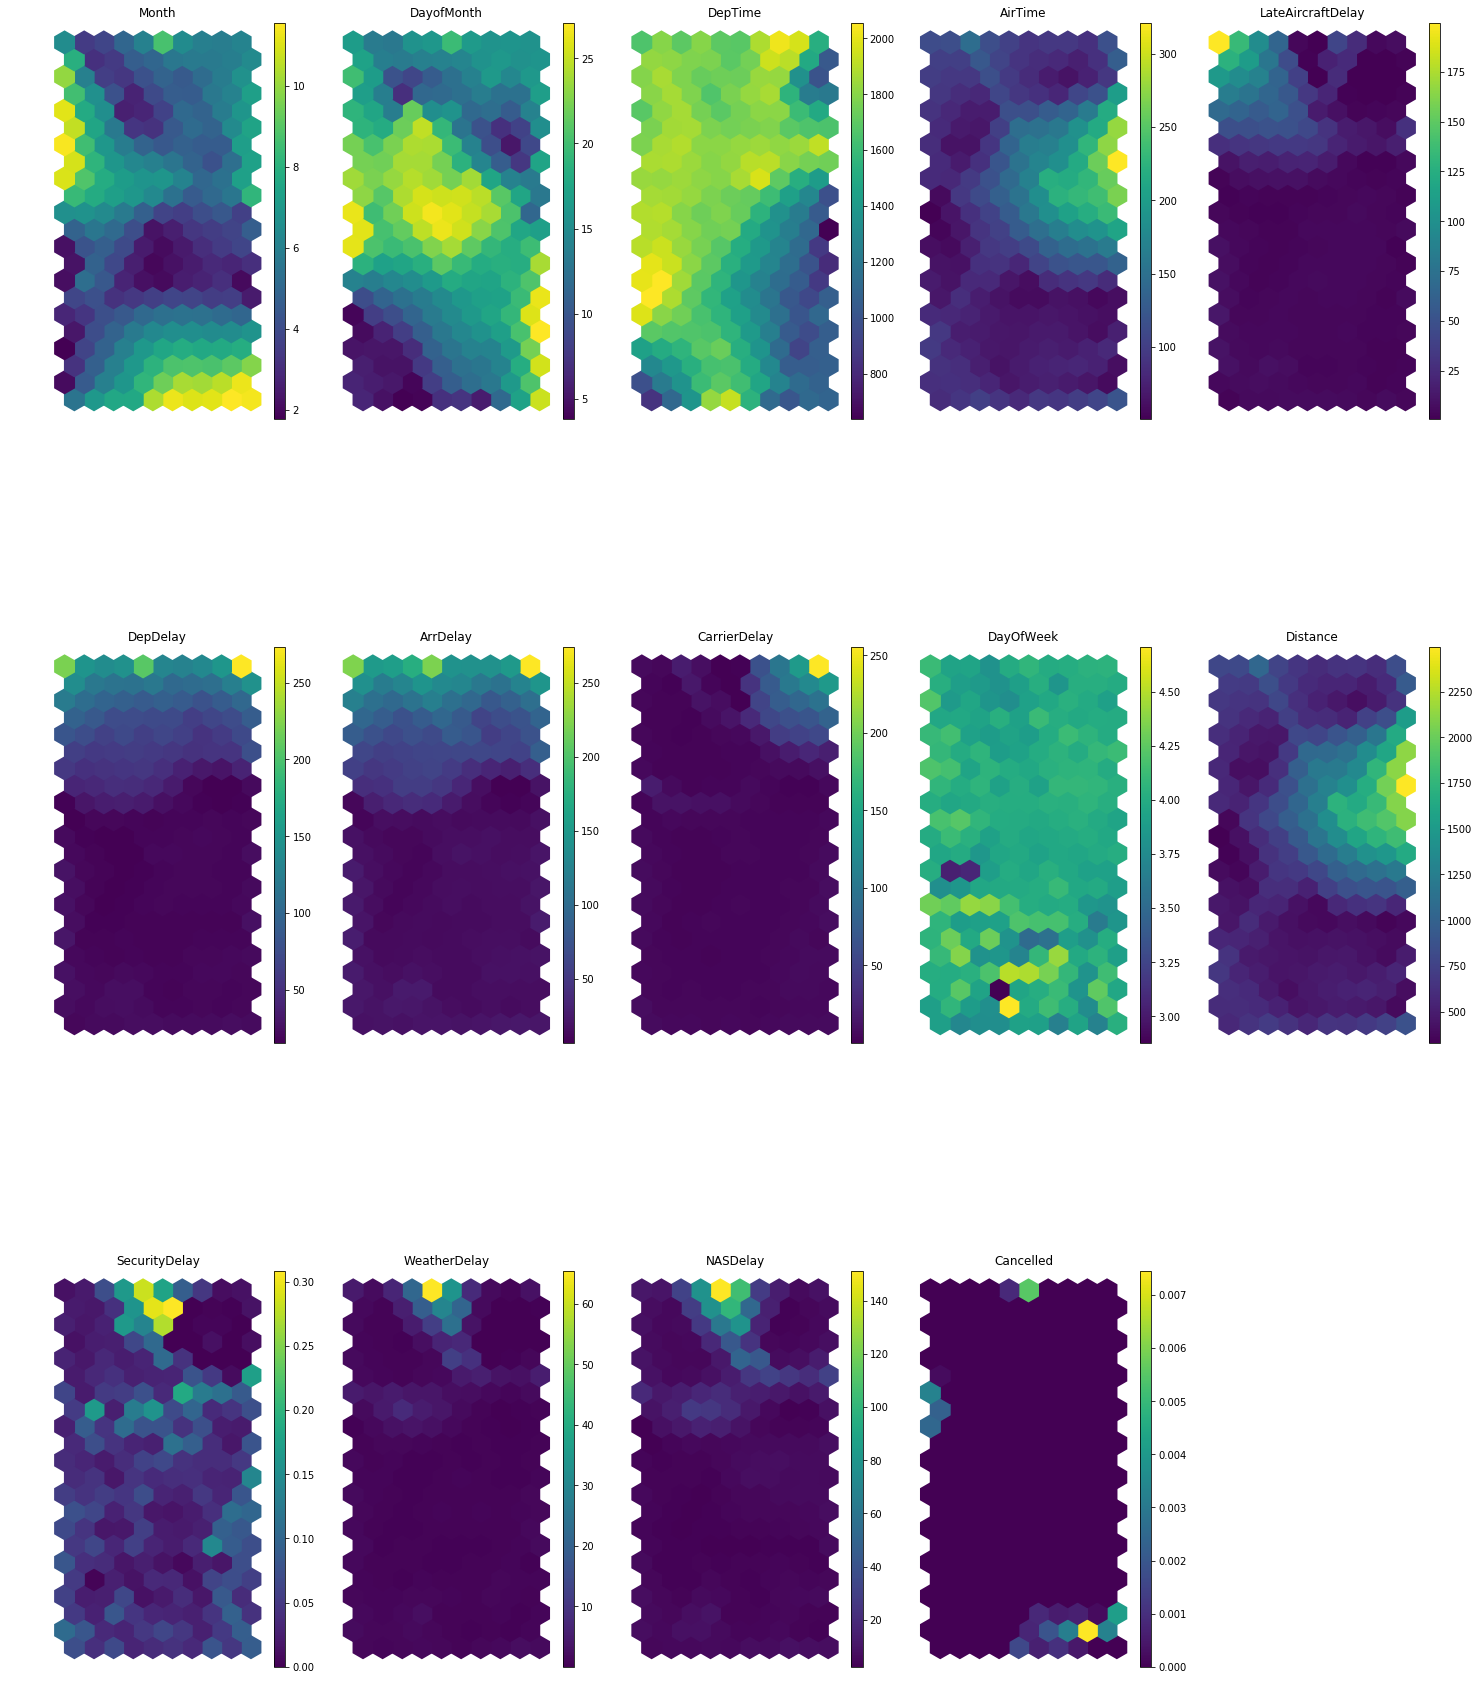

In [7]:
# Addition of some exogeneous variables to the map
exogeneous_vars = [c for c in df.columns if not c in clustering_vars+["Cancelled", "bmus"]] 
df["bmus"] = sm.project_data(data)
df = df[clustering_vars + exogeneous_vars + ["Cancelled"] + ["bmus"]]

empirical_codebook=df.groupby("bmus").mean().values
matplotlib.rcParams.update({'font.size': 10})
plot_hex_map(empirical_codebook.reshape(sm.codebook.mapsize + [empirical_codebook.shape[-1]]), 
             titles=df.columns[:-1], shape=[4, 5], colormap=None)
plt.show()

### Hits-map 

This visualization is very important because it shows how the instances are spreaded across the hexagonal lattice. The more instances lay into a cell, the more instances it is representing and hence the more we have to take it into acount

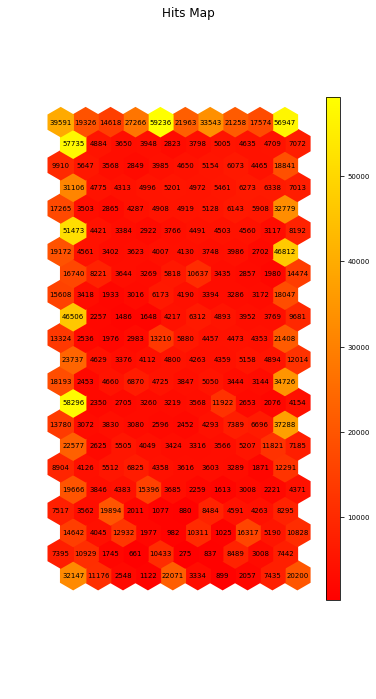

In [8]:
from sompy.visualization.bmuhits import BmuHitsView
#sm.codebook.lattice="rect"
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="autumn", logaritmic=False)
plt.show()


### Clustering 

This visualization helps us to focus on the groups which share similar characteristics

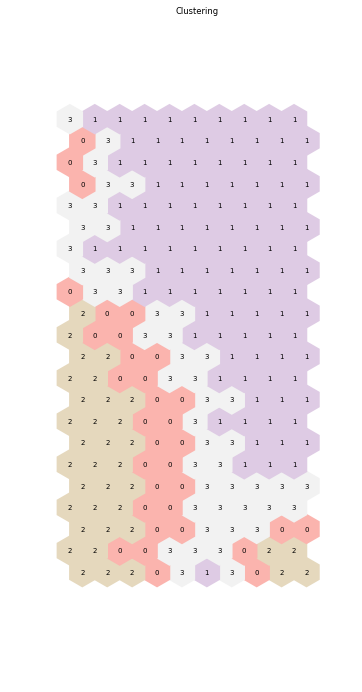

In [9]:
from sompy.visualization.hitmap import HitMapView
sm.cluster(4)

hits  = HitMapView(12, 12,"Clustering",text_size=10, cmap=plt.cm.jet)
a=hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")
plt.show()

## Conclusions 

Looking at the components map and comparing each component with the cancellation component, a set of conclusions can be extracted. The main ones are summarized below
- The flight cancellations highly depend on the month. Late year flights are much more likely to suffer cancellations than early year flights
- The flight cancellations occur much more often in short flights than in longer flights
- The delays occuring on the previous flights, departures, arrivals, because of security reasons and because of the National Air Systems are not typically drivers for the flight cancellations

Apart from these ones, secondary conclusions can be extracted by comparing all the components together. A couple of examples is summarized below
- The majority of the delays occur in the afternoon
- The short time flights are the most prone to suffer delays

<div style="text-align: right"> Iván Vallés Pérez - 14/10/2018 </div>